# Metric_selection

The choice of metric depends on what we want to predict. In our case we are interested in minimizing the prediction errors of the minority class(False Negative Rate). Also, since we want it to be independent of the threshold, we are going to evaluate the model's performace with roc-auc curves.

# CONTENT

    1. Import Libraries
    2. Load data
    3. Train models:
        3.1. Baseline predictions
        3.2. 

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


#Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB



from sklearn.metrics import (
    roc_auc_score,
    plot_roc_curve,
    plot_precision_recall_curve
)
from sklearn.metrics import accuracy_score

#show cells with width as long as screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
)

In [5]:
#pip install pydotplus

In [6]:
#!pip install -U graphviz

In [7]:
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)

# 2. Load data

Load data generated in **step_2** notebook

In [8]:
X_train = pd.read_excel('X_train_step_2.xlsx', engine='openpyxl').values
X_test =  pd.read_excel('X_test_step_2.xlsx', engine='openpyxl').values
y_train = pd.read_excel('y_train_step_2.xlsx', engine='openpyxl').values
y_test = pd.read_excel('y_test_step_2.xlsx', engine='openpyxl').values

Let's remember that this is an imbalanced dataset:

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
y_train_values= dict(zip(unique, counts))
majority_class = y_train_values[0]/len(y_train) *100
minority_class = y_train_values[1]/len(y_train) *100

In [10]:
print('% majority class is', majority_class, 'and % minority class is', minority_class)

% majority class is 83.9506172839506 and % minority class is 16.049382716049383


# 3. Train models

In principle accuracy is the most used metric, however we are going to see that in spite of obtaining good performance values, it is not a good metric for cases of imbalanced classes.

We are going to prove that the accuracy metric affects algorithms in their information generalization process, harming minority classes.

For this purpose, we will define a function for calculating the percentage of hits for different models

## Accuracy

**Fraction of percentage of correct predictions**

binary clasiffication:

Accuracy = (TP + TN) / total number of predictions

In [11]:
def return_minority_perc(y_true, y_pred):
    
    ''' Calculates the percentage of successes of the classification binary model in the minority class.
    Majority class = 0
    Minority class = 1

    y_true = y values of test_set
    y_pred = y values predicted by the model for X_test
    
    '''
    
    return np.sum(np.where((y_true==1)&(y_pred==1),1,0))

###  3. 1 Baseline prediction: predict ALWAYS the majority class

In order to predict only the majority class, we construct a matrix of zeros with the same length of train_set and test_set

In [12]:
y_train_base = np.zeros(len(y_train))
y_test_base = np.zeros(len(y_test))

In [13]:
print('Accuracy Baseline test: ', accuracy_score(y_test, y_test_base))

Accuracy Baseline test:  0.8395061728395061


This result is to be expected because, as we said, it only predicts the majority class, i.e. 84%.

It is correct in 84% of the cases because our dataset was imbalanced 84:16. 
84% belongs to mayority class.

In [14]:
print('% minority correctly classified, Baseline test: ', return_minority_perc(y_test, y_test_base))

% minority correctly classified, Baseline test:  0


As we expected, the result is zero

Other metrics can be obtained by classification report tool which shows the main classification metrics

In [15]:
print(classification_report(y_test,y_test_base))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        68
           1       0.00      0.00      0.00        13

    accuracy                           0.84        81
   macro avg       0.42      0.50      0.46        81
weighted avg       0.70      0.84      0.77        81



**In order to visualize the performance of classification algorithm, we will be using CONFUSION MATRIX**

Confusion Matrix is a tool that shows us the performance of a classification algorithm, describing how the actual values and our predictions are distributed.

In [16]:
cf_matrix=confusion_matrix(y_test,y_test_base)
cf_matrix

array([[68,  0],
       [13,  0]], dtype=int64)

Always predicts the majority class

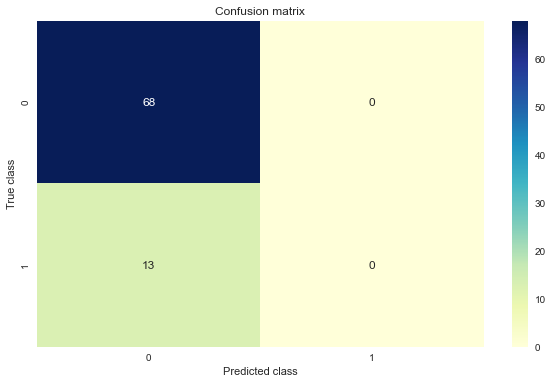

In [17]:
cf_matrix=confusion_matrix(y_test,y_test_base)
fig_1 = plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu" );
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### **Other metrics**

**FPR(False positive rate) and FNR(False negative rate)**

It is not a metric but In our case we want to minimize FNR because we want minimize the number of sick people that we do not diagnoses correctly

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_base, labels=[0,1]).ravel()

FPR = fp / (tn + fp)

FNR = fn / (tp + fn)

print('False Positive Rate, baseline: ', FPR)
print('False Negative Rate, baseline: ', FNR)

False Positive Rate, baseline:  0.0
False Negative Rate, baseline:  1.0


**ROC-AUC(Receiving Operating Characteristic - Area Under Curve)**

**AUC** provides an aggregate measure of performance across all possible classification thresholds.

Higher AUC indicates the model is better at predicting both classes



In [19]:
print('ROC-AUC Baseline test: ', roc_auc_score(y_test, y_test_base))

ROC-AUC Baseline test:  0.5


AUC takes values from 1 to 0.5:

    -AUC=1 for a perfect model 
    -AUC=0.5 for a random model 

# 3.3 Models

We will quickly apply simple models, without tuning hyperparameters:

In [20]:
random_state = 42
classifiers_dict = {
    'SVC' : SVC(random_state=random_state, probability=True),
    'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
    'AdaBoostClassifier':AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
    'RandomForestClassifier': RandomForestClassifier(random_state=random_state),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=random_state),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state = random_state)
}

In [22]:
cv_results = []
for classifier in classifiers_dict.keys() :
    print(classifier)
    cv_results.append(cross_val_score(classifiers_dict[classifier], X_train, y_train, scoring = "accuracy", cv = 3, n_jobs=4))
    
cv_results

SVC
DecisionTreeClassifier
AdaBoostClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier
KNeighborsClassifier
LogisticRegression


[array([0.84259259, 0.84259259, 0.83333333]),
 array([0.40740741, 0.55555556, 0.49074074]),
 array([0.39814815, 0.58333333, 0.5       ]),
 array([0.71296296, 0.77777778, 0.83333333]),
 array([0.58333333, 0.75      , 0.83333333]),
 array([0.57407407, 0.65740741, 0.67592593]),
 array([0.78703704, 0.80555556, 0.80555556]),
 array([0.58333333, 0.69444444, 0.84259259])]

In [23]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [24]:
len(cv_std)

8

In [25]:
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression"]})


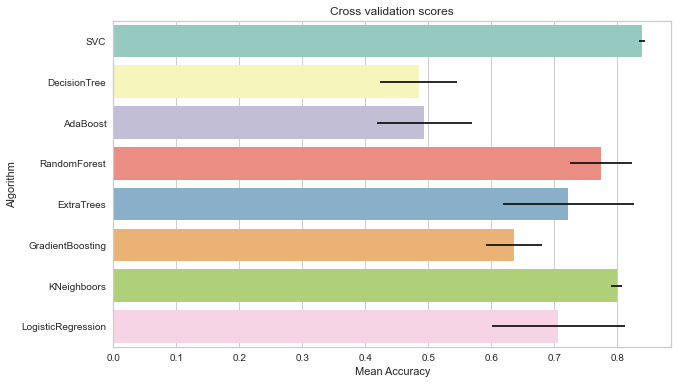

In [26]:
plt.figure(figsize=(10, 6))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [29]:
hacer cf de todos

SyntaxError: invalid syntax (<ipython-input-29-ff0f03e1e842>, line 1)

### 3.2 Logistic Regression

In [27]:
clf_2 = LogisticRegression(random_state=0,  max_iter=1000)

clf_2.fit(X_train, y_train)

#y_train_clf_2 = clf_2.predict_proba(X_train)[:,1]
#y_test_clf_2 = clf_2.predict_proba(X_test)[:,1]

LogisticRegression(max_iter=1000, random_state=0)

In [28]:
print('Accuracy Logistic Regression test:', accuracy_score(y_test, clf_2.predict(X_test)))

Accuracy Logistic Regression test: 0.8395061728395061


In [29]:
print('% minority correctly classified, Regression test:', return_minority_perc(y_test, clf_2.predict(X_test)))

% minority correctly classified, Regression test: 0


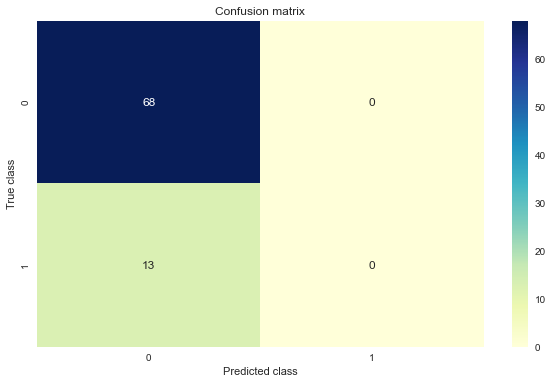

In [30]:
cf_matrix=confusion_matrix(y_test,clf_2.predict(X_test))
plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu" );
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [31]:
print(classification_report(y_test,clf_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        68
           1       0.00      0.00      0.00        13

    accuracy                           0.84        81
   macro avg       0.42      0.50      0.46        81
weighted avg       0.70      0.84      0.77        81



Plot of classification report with yellowbrick pakages

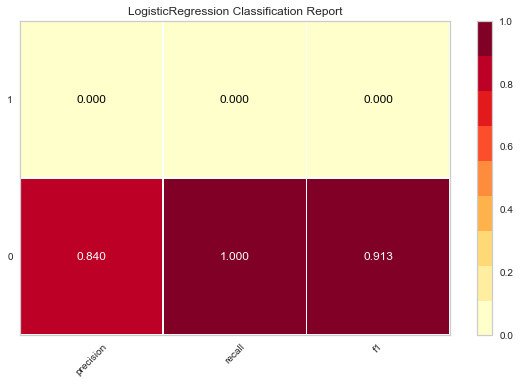

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [32]:
visualizer = ClassificationReport(clf_2)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

**Precision and Recall, vs probability threshold**

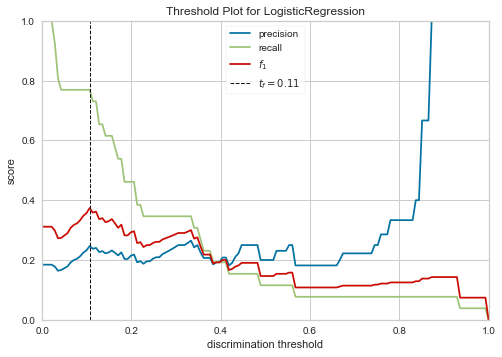

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [33]:
visualizer = DiscriminationThreshold(clf_2,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

**FPR and FNR**

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, clf_2.predict(X_test), labels=[0,1]).ravel()

FPR = fp / (tn + fp)

FNR =  fn / (tp + fn)

print('False Positive Rate, Logistic Regression: ', FPR)
print('False Negative Rate, Logistic Regression: ', FNR)

False Positive Rate, Logistic Regression:  0.0
False Negative Rate, Logistic Regression:  1.0


### 3.3 KNeighbors

In [35]:
clf_gk = GridSearchCV(KNeighborsClassifier(),
                   param_grid={"n_neighbors":np.arange(1,3)},
                   scoring="accuracy")
clf_gk.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2])}, scoring='accuracy')

**ojo: Bajando el número de n_neighbors, me mejora la predicción**

In [36]:
print('Accuracy KNeighbors test:', accuracy_score(y_test, clf_gk.predict(X_test)))

Accuracy KNeighbors test: 0.8271604938271605


In [37]:
print('% minority correctly classified, Regression test:', return_minority_perc(y_test, clf_gk.predict(X_test)))

% minority correctly classified, Regression test: 91


In [38]:
confusion_matrix(y_test,clf_gk.predict(X_test

SyntaxError: unexpected EOF while parsing (<ipython-input-38-91dc8e46f45d>, line 1)

In [39]:
print(classification_report(y_test,clf_gk.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        68
           1       0.43      0.23      0.30        13

    accuracy                           0.83        81
   macro avg       0.65      0.59      0.60        81
weighted avg       0.79      0.83      0.80        81



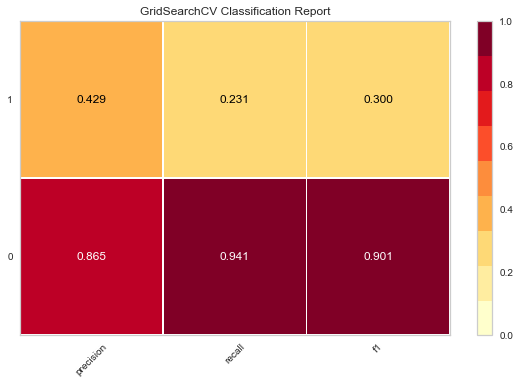

<AxesSubplot:title={'center':'GridSearchCV Classification Report'}>

In [40]:
visualizer = ClassificationReport(clf_gk)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

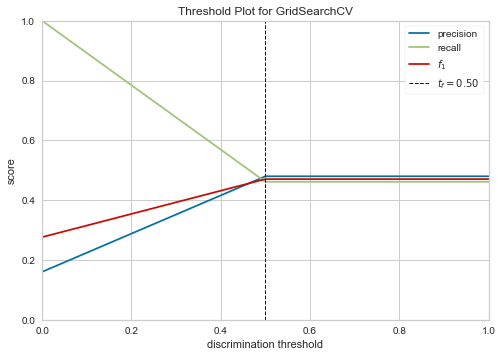

<AxesSubplot:title={'center':'Threshold Plot for GridSearchCV'}, xlabel='discrimination threshold', ylabel='score'>

In [41]:
visualizer = DiscriminationThreshold(clf_gk,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

### 3.4 Decision Trees

In [42]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
print('Accuracy Decision tree test:', accuracy_score(y_test, dtc.predict(X_test)))

Accuracy Decision tree test: 0.7777777777777778


In [44]:
print('% minority correctly classified, Decision tree test:', return_minority_perc(y_test, dtc.predict(X_test)))

% minority correctly classified, Decision tree test: 169


In [45]:
from IPython.display import Image

from sklearn.tree import export_graphvizs
import pydotplus
from io import StringIO
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,filled=True, rounded=True,
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

ImportError: cannot import name 'export_graphvizs' from 'sklearn.tree' (C:\Users\Omen\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\__init__.py)

### 3.5 Support Vector Machine

In [47]:
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [48]:
print('Accuracy SVM test:', accuracy_score(y_test, svc.predict(X_test)))

Accuracy SVM test: 0.8395061728395061


In [49]:
print('% minority correctly classified, Regression test:', return_minority_perc(y_test, svc.predict(X_test)))

% minority correctly classified, Regression test: 0


In [50]:
confusion_matrix(y_test,svc.predict(X_test))

array([[68,  0],
       [13,  0]], dtype=int64)

In [51]:
print(classification_report(y_test,svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        68
           1       0.00      0.00      0.00        13

    accuracy                           0.84        81
   macro avg       0.42      0.50      0.46        81
weighted avg       0.70      0.84      0.77        81



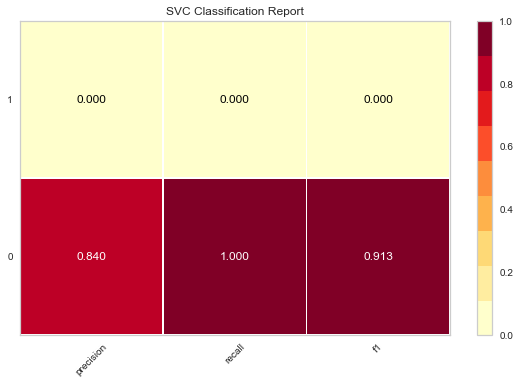

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [52]:
visualizer = ClassificationReport(svc)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

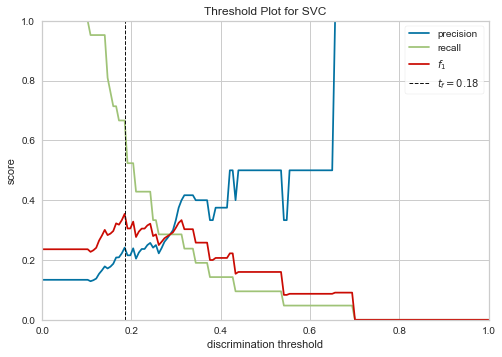

<AxesSubplot:title={'center':'Threshold Plot for SVC'}, xlabel='discrimination threshold', ylabel='score'>

In [53]:
visualizer = DiscriminationThreshold(svc,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=42,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

### 3.7 Random Forest

In [57]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [58]:
print('Accuracy Random Forest test:', accuracy_score(y_test, rf.predict(X_test)))

Accuracy Random Forest test: 0.8271604938271605


In [59]:
print('% minority correctly classified, Random Forest test:', return_minority_perc(y_test, rf.predict(X_test)))

% minority correctly classified, Random Forest test: 91


In [60]:
confusion_matrix(y_test,rf.predict(X_test))

array([[64,  4],
       [10,  3]], dtype=int64)

In [61]:
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        68
           1       0.43      0.23      0.30        13

    accuracy                           0.83        81
   macro avg       0.65      0.59      0.60        81
weighted avg       0.79      0.83      0.80        81



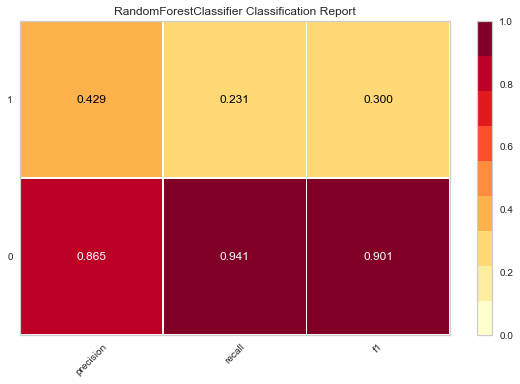

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [62]:
visualizer = ClassificationReport(rf)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

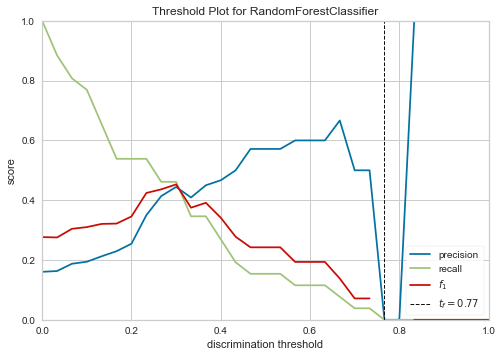

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [63]:
visualizer = DiscriminationThreshold(rf,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

**FPR and FNR**

In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, rf.predict(X_test), labels=[0,1]).ravel()

FPR = fp / (tn + fp)

FNR =  fn / (tp + fn)

print('False Positive Rate, Random Forests: ', FPR)
print('False Negative Rate, Random Forests: ', FNR)

False Positive Rate, Random Forests:  0.058823529411764705
False Negative Rate, Random Forests:  0.7692307692307693


**FPR and FNR vs probability threshold**

In [65]:
thresholds = np.linspace(0, 1, 100)


In [66]:
fpr_ls = []
fnr_ls = []

# obtain probabilities
probs = rf.predict_proba(X_test)[:,1]

for threshold in thresholds:   
    
    # obtain class prediction based on threshold
    preds = np.where(probs>=threshold, 1, 0)
    
    # obtain confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0,1]).ravel()
    
    #  obtain FRP and FNR
    FPR = fp / (tn + fp)
    FNR =  fn / (tp + fn)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)
    
metrics = pd.concat([
    pd.Series(fpr_ls),
    pd.Series(fnr_ls)], axis=1)

metrics.columns = ['fpr', 'fnr']
metrics.index = thresholds

Text(0.5, 1.0, 'FPR and FNR vs Discriminant Threshold')

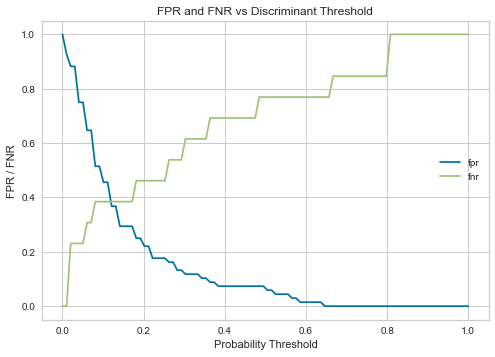

In [67]:
metrics.plot()
plt.xlabel('Probability Threshold')
plt.ylabel('FPR / FNR')
plt.title('FPR and FNR vs Discriminant Threshold')

# ROC-AUC

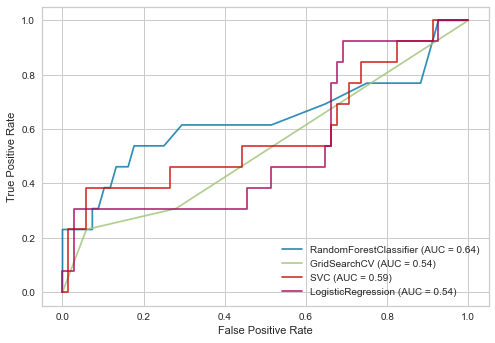

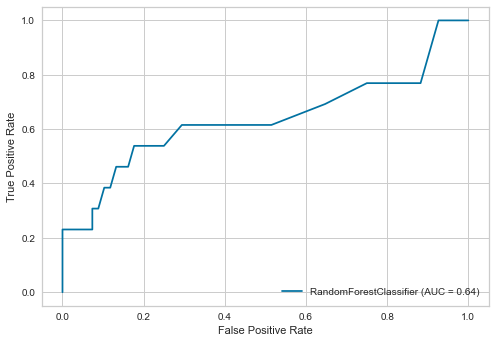

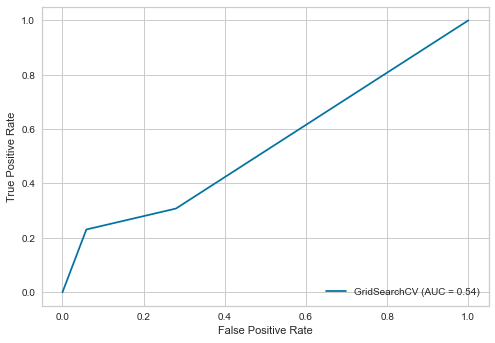

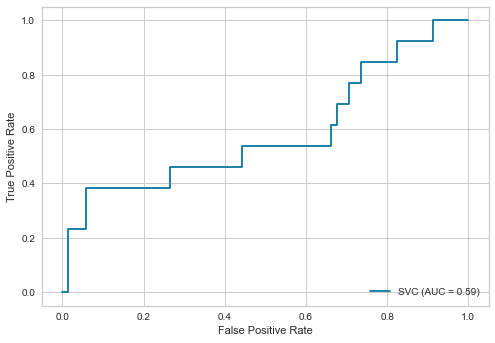

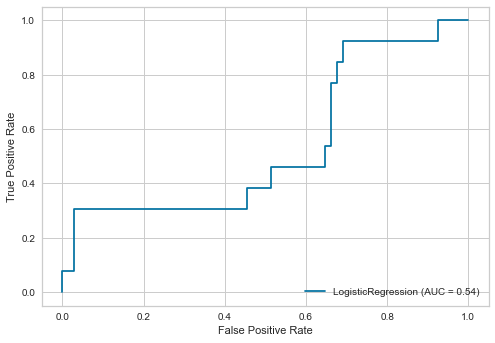

In [68]:
ax = plt.gca()
plot_roc_curve(rf, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_roc_curve(clf_gk, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_roc_curve(svc, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_roc_curve(clf_2, X_test, y_test).plot(ax=ax, alpha=0.8)

We can  that RF Classifier is better throughout the discrimination threshold.It present the higher area under the curve(AUC) it's mean higher model performance.

We also observe that SVC and LR cross each other indicating that performance of SVC model is better for higher threshold and for lower thershods is better LR.

In [69]:
print('ROC-AUC Random Forest test:', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
print('ROC-AUC Logistic Regression test:', roc_auc_score(y_test, clf_2.predict_proba(X_test)[:,1]))
print('ROC-AUC KNN test:', roc_auc_score(y_test, clf_gk.predict_proba(X_test)[:,1]))
print('ROC-AUC SVC test:', roc_auc_score(y_test, svc.predict_proba(X_test)[:,1]))

ROC-AUC Random Forest test: 0.6363122171945701
ROC-AUC Logistic Regression test: 0.5395927601809956
ROC-AUC KNN test: 0.5373303167420814
ROC-AUC SVC test: 0.585972850678733


# Precision-Recall curves

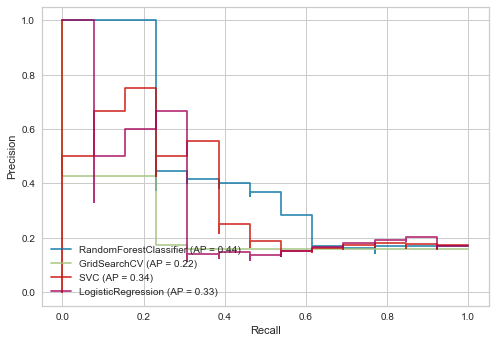

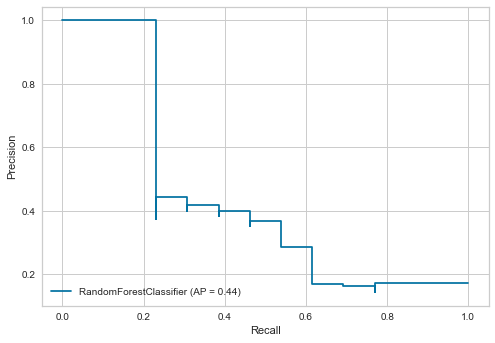

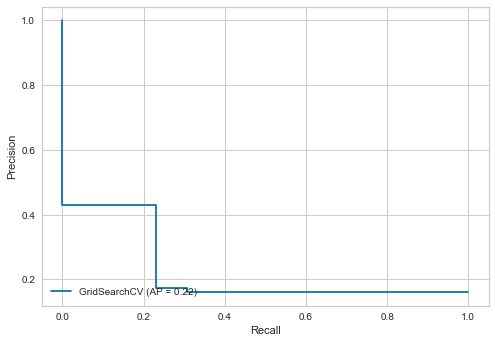

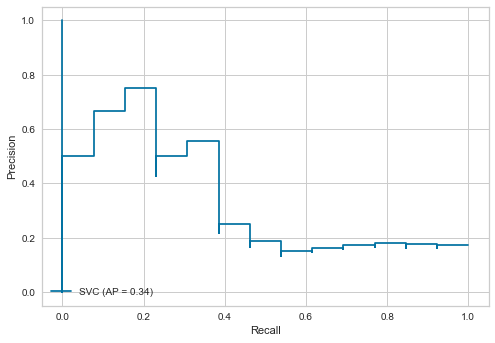

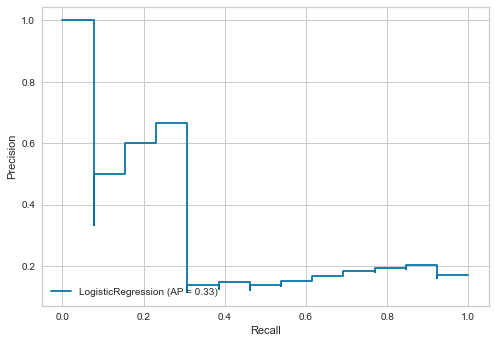

In [70]:
ax = plt.gca()
plot_precision_recall_curve(rf, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_precision_recall_curve(clf_gk, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_precision_recall_curve(svc, X_test, y_test).plot(ax=ax, alpha=0.8)
plot_precision_recall_curve(clf_2, X_test, y_test).plot(ax=ax, alpha=0.8)

In [72]:
ax1

<AxesSubplot:>

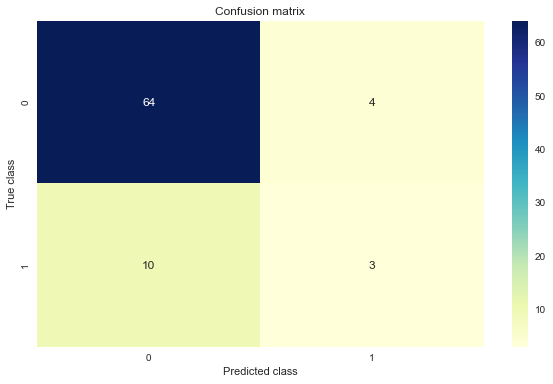

In [76]:
cf_matrix=confusion_matrix(y_test,rf.predict(X_test))
plt.figure(figsize=(10, 6))
ax1 = sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu" );
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

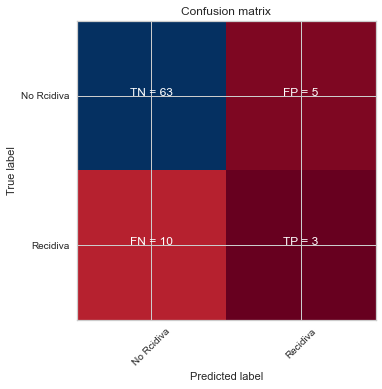

Recall=0.231 
Precision=0.375
F1=0.286
False Positive Rate=0.074
False Negative Rate=0.769


NameError: name 'plot_aucprc' is not defined

In [86]:
pre = RandomForestClassifier(n_jobs=-1, random_state = 42,
                             max_features= 'sqrt', 
                             criterion = 'entropy')
pre.fit(X_train, y_train)

#Make predictions
y_pred = pre.predict(X_test)
try:
    scores = pre.decision_function(X_test)
except:
    scores = pre.predict_proba(X_test)[:,1]

#Make plots
plot_cm(pre, y_pred)
plot_aucprc(pre, scores)

In [84]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['No Rcidiva','Recidiva']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    plt.title("Confusion matrix")
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)
    FPR = fp / (tn + fp)
    FNR = fn / (tp + fn)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))
    print('False Positive Rate={0:0.3f}'.format(FPR))
    print('False Negative Rate={0:0.3f}'.format(FNR))
    

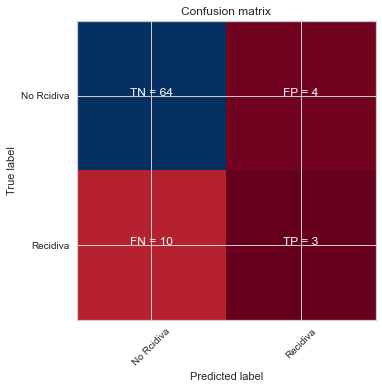

Recall=0.231 
Precision=0.429
F1=0.300
False Positive Rate=0.059
False Negative Rate=0.769


In [85]:
plot_cm(rf,rf.predict(X_test))

**Conclusion** : Despite having good accuracy values, we have actually found that it is not sensitive to the minority class which in this case is our interest.

In [ ]:
hacer analisis de lo que nos interesa, poniendo todoas la confusion matrix ver cual tiene el mejor FN ratio que es lo que nos interesa

**Conclusion**: In order to evaluate the performance of our model we will use the roc-auc metric analyzing the confusion matrix and the False Negative Rate(FNR).

Possible metrics:

In [155]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']